   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality  Id  
0      9.4        5   0  
1      9.8        5   1  
2      9

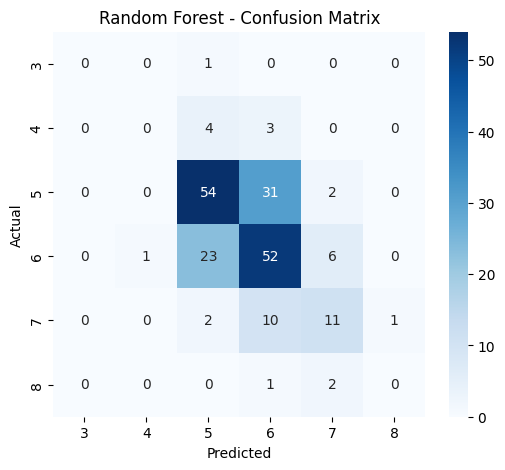


--- Training SGD Classifier ---
SGD Classifier Accuracy: 0.5343
Classification Report:
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00         7
           5       0.56      0.72      0.63        87
           6       0.53      0.52      0.53        82
           7       0.50      0.08      0.14        24
           8       1.00      0.33      0.50         3

    accuracy                           0.53       204
   macro avg       0.43      0.28      0.30       204
weighted avg       0.52      0.53      0.50       204



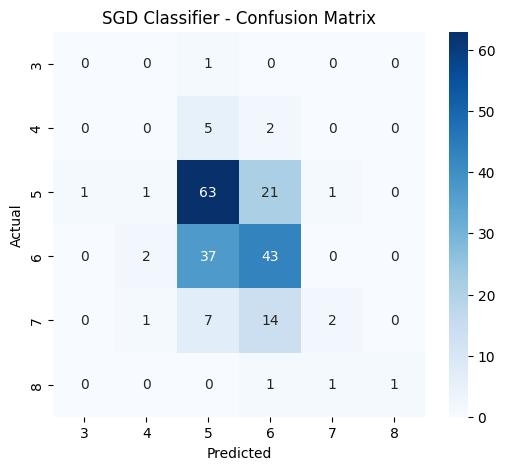


--- Training SVC ---
SVC Accuracy: 0.6029
Classification Report:
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00         7
           5       0.65      0.75      0.70        87
           6       0.56      0.60      0.58        82
           7       0.56      0.38      0.45        24
           8       0.00      0.00      0.00         3

    accuracy                           0.60       204
   macro avg       0.29      0.29      0.29       204
weighted avg       0.57      0.60      0.58       204



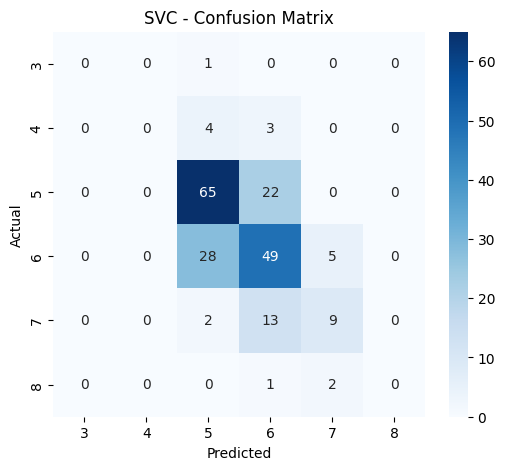

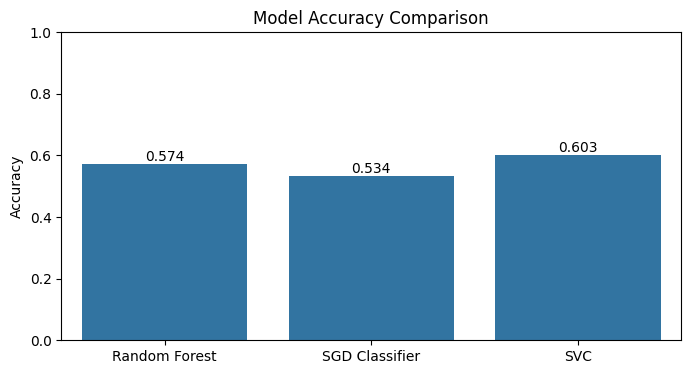


Final accuracies:
Random Forest: 0.5735
SGD Classifier: 0.5343
SVC: 0.6029


In [2]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
csv_path = "/content/WineQT.csv"
random_state = 42
df = pd.read_csv(csv_path)
print(df.head())
print(df.info())
print(df.describe())
print("\nMissing values:\n", df.isnull().sum())
if 'Id' in df.columns:
    df = df.drop('Id', axis=1)
df = df.drop_duplicates()
if 'quality' not in df.columns:
    raise ValueError("Dataset must contain a 'quality' column for this script to work.")
cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
if cat_cols:
    df = pd.get_dummies(df, columns=cat_cols, drop_first=True)
if np.issubdtype(df['quality'].dtype, np.floating):
    if np.allclose(df['quality'], df['quality'].round()):
        df['quality'] = df['quality'].round().astype(int)
    else:
        raise ValueError(
            "Target 'quality' appears to be continuous non-integer values. "
            "If you intend classification, convert/bucketize the target first."
        )
X = df.drop('quality', axis=1)
y = df['quality']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=random_state, stratify=y
)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=random_state, n_jobs=-1),
    "SGD Classifier": SGDClassifier(max_iter=2000, tol=1e-3, random_state=random_state),
    "SVC": SVC(kernel='rbf', probability=False, random_state=random_state)
}
results = {}
for name, model in models.items():
    print(f"\n--- Training {name} ---")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    results[name] = acc
    print(f"{name} Accuracy: {acc:.4f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred, zero_division=0))
    labels = np.unique(np.concatenate([y_test, y_pred]))
    cm = confusion_matrix(y_test, y_pred, labels=labels)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels)
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

plt.figure(figsize=(8, 4))
sns.barplot(x=list(results.keys()), y=list(results.values()))
plt.ylim(0, 1)
plt.ylabel("Accuracy")
plt.title("Model Accuracy Comparison")
for i, v in enumerate(results.values()):
    plt.text(i, v + 0.01, f"{v:.3f}", ha='center')
plt.show()
print("\nFinal accuracies:")
for name, acc in results.items():
    print(f"{name}: {acc:.4f}")

